## Montage and topographic map

This notebook shows how to create a montage and a topographic map of the brain using the MNE-Python library.

In [47]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import mne
import copy
import os
os.chdir('../src_code')
from utils.plot_functions import plot_topographic_map_freq

Read file for the first subject from folder.
Data can be downloaded @ https://physionet.org/content/eegmat/1.0.0/, for each of the 36 subjects there are 2 files, lasting 3 minutes and 1 minute respectively. The first file is the one we are going to use.

In [49]:
# read file from folder
data_path = '../eeg_data'
raw = mne.io.read_raw_edf(f'{data_path}/Subject00_1.edf', preload=True, verbose=False)
raw.info

Measurement date,"January 01, 2011 00:00:00 GMT"
Experimenter,Unknown
Participant,0
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,45.00 Hz


The sampling frequency is 500Hz, so we have ~90000 samples for each channel.

In [51]:
for i in range(len(raw.info['chs'])):
    print(f"Channel {i+1}: {raw.info['chs'][i]['ch_name']}, data points: {len(raw._data[i])}")

Channel 1: EEG Fp1, data points: 91000
Channel 2: EEG Fp2, data points: 91000
Channel 3: EEG F3, data points: 91000
Channel 4: EEG F4, data points: 91000
Channel 5: EEG F7, data points: 91000
Channel 6: EEG F8, data points: 91000
Channel 7: EEG T3, data points: 91000
Channel 8: EEG T4, data points: 91000
Channel 9: EEG C3, data points: 91000
Channel 10: EEG C4, data points: 91000
Channel 11: EEG T5, data points: 91000
Channel 12: EEG T6, data points: 91000
Channel 13: EEG P3, data points: 91000
Channel 14: EEG P4, data points: 91000
Channel 15: EEG O1, data points: 91000
Channel 16: EEG O2, data points: 91000
Channel 17: EEG Fz, data points: 91000
Channel 18: EEG Cz, data points: 91000
Channel 19: EEG Pz, data points: 91000
Channel 20: EEG A2-A1, data points: 91000
Channel 21: ECG ECG, data points: 91000


Plot the raw data and the montage.

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

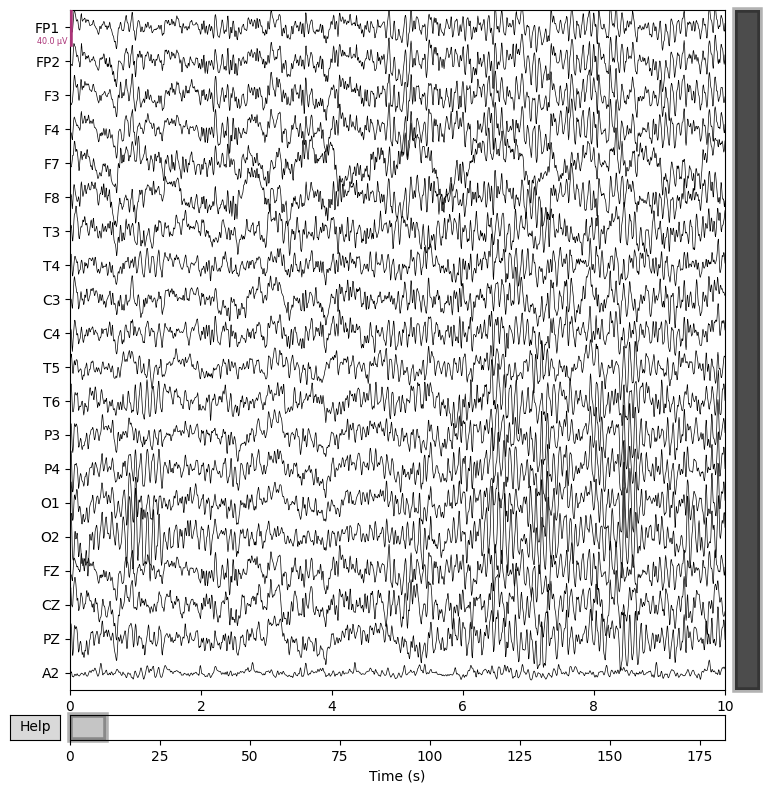

In [53]:
# rename raw channels
raw.rename_channels(lambda x: x.upper()[4:]) # just to make it easier to read
# remove ECG channel
raw.drop_channels(['ECG'])
# and name A2-A1 as A2
raw.rename_channels({'A2-A1': 'A2'})

raw.plot();

Obtain a representation of our montage starting from one available in the MNE library.

In [55]:
# montage available in mne
montage = mne.channels.make_standard_montage('standard_1020')

# make a copy of montage positions
montage_pos = copy.deepcopy(montage._get_ch_pos())

# remove from montage_pos the channels that are not in raw
montage_pos = {k.upper(): v for k, v in montage_pos.items()}
electrode_dicts = {ch_name: montage_pos[ch_name] for ch_name in raw.info['ch_names']}

# get fiducial points
fid = montage.dig
nasion = fid[1]['r']  # Nasion point
lpa = fid[0]['r']  # Left point
rpa = fid[2]['r']  # Right point

custom_montage = mne.channels.make_dig_montage(nasion = nasion, lpa=lpa, rpa=rpa, ch_pos = electrode_dicts)


Set the montage for our raw data.

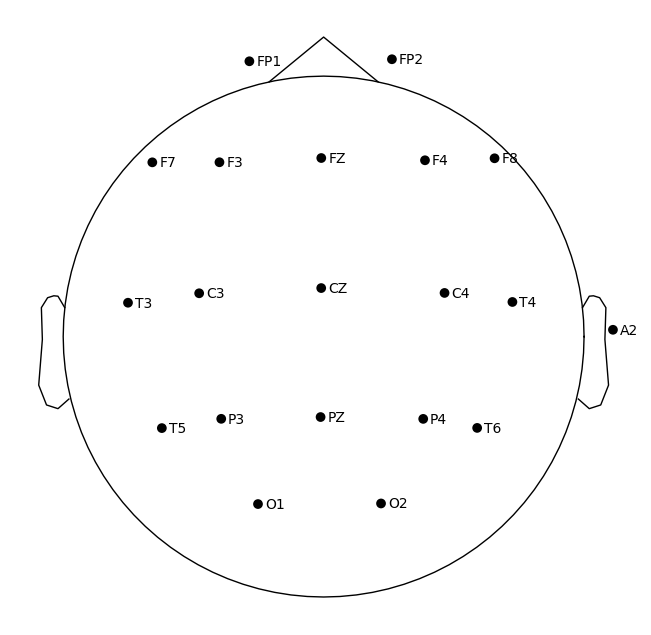

In [57]:
# mount the montage on the raw data
raw.set_montage(custom_montage)

# plot the montage on the raw data
raw.plot_sensors(show_names=True);

In [59]:
# get positions from custom montage
custom_montage_pos = custom_montage._get_ch_pos()
custom_montage_pos

OrderedDict([('FP1', array([-0.0294367,  0.0839171, -0.00699  ])),
             ('FP2', array([ 0.0298723,  0.0848959, -0.00708  ])),
             ('F3', array([-0.0502438,  0.0531112,  0.042192 ])),
             ('F4', array([0.0518362, 0.0543048, 0.040814 ])),
             ('F7', array([-0.0702629,  0.0424743, -0.01142  ])),
             ('F8', array([ 0.0730431,  0.0444217, -0.012    ])),
             ('T3', array([-0.0841611, -0.0160187, -0.009346 ])),
             ('T4', array([ 0.0850799, -0.0150203, -0.00949  ])),
             ('C3', array([-0.0653581, -0.0116317,  0.064358 ])),
             ('C4', array([ 0.0671179, -0.0109003,  0.06358  ])),
             ('T5', array([-0.0724343, -0.0734527, -0.002487 ])),
             ('T6', array([ 0.0730557, -0.0730683, -0.00254  ])),
             ('P3', array([-0.0530073, -0.0787878,  0.05594  ])),
             ('P4', array([ 0.0556667, -0.0785602,  0.056561 ])),
             ('O1', array([-0.0294134, -0.112449 ,  0.008839 ])),
           

Montage positions are saved like a 3D vector, as the positions are in 3D space. 
However the function `plot_sensors` from MNE library use a 2D vector and obtain it through another function `mne.viz.topomap._get_pos_outlines`.

We will use this coordinates to plot the topomap.

In [61]:
pos_2d = mne.viz.topomap._get_pos_outlines(raw.info, picks=None, sphere=None)[0]
pos_2d

array([[-0.02708246,  0.10042033],
       [ 0.02491507,  0.10115847],
       [-0.03800103,  0.06358406],
       [ 0.03697464,  0.0643073 ],
       [-0.06248761,  0.06355424],
       [ 0.06235232,  0.06503185],
       [-0.07135999,  0.01234257],
       [ 0.06886155,  0.01261933],
       [-0.04540056,  0.01579295],
       [ 0.04410569,  0.01591498],
       [-0.05901261, -0.03338525],
       [ 0.05600343, -0.03331862],
       [-0.03734978, -0.03000179],
       [ 0.03632535, -0.03002585],
       [-0.02394173, -0.06109372],
       [ 0.02093874, -0.06087955],
       [-0.00085833,  0.06512851],
       [-0.00088035,  0.01769319],
       [-0.00110991, -0.02935592],
       [ 0.10553739,  0.00247447]])

## Plot topographic maps

Now we can plot the topographic maps for all the channels. EEG topographic maps (topomap) provide an idea of the brain activation in different regions of the brain. The topomap is a 2D representation of the scalp, where the color of each point represents the activity of the brain in that region.

In [63]:
# data is stored in raw._data
data = raw.get_data() 
print(data.shape, type(data))

# positions of the electrodes in 2d
positions = np.zeros((len(raw.ch_names), 2))

for ch in raw.ch_names:
    idx = raw.ch_names.index(ch)
    positions[raw.ch_names.index(ch), :] = [pos_2d[idx][0], pos_2d[idx][1] -0.02] # apply a small correction to the 2d pos for visualization purposes


(20, 91000) <class 'numpy.ndarray'>


Plot the topographic maps at a specific time point.

<Figure size 1000x1000 with 0 Axes>

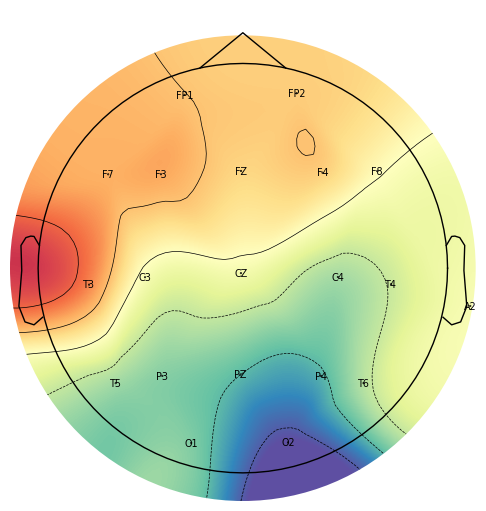

In [65]:
# Plot topographic map
plt.figure(figsize=(10,10))
mne.viz.plot_topomap(data[:, 100], positions, ch_type='eeg', cmap="Spectral_r", size=5, show=True, names=raw.ch_names);


A more detailed visualization, showing brain activation at four different time points.

<Figure size 5000x1000 with 0 Axes>

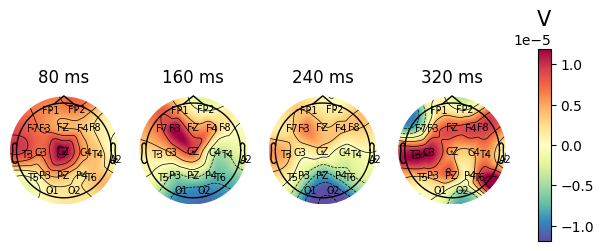

In [67]:
def plot_topomap(data, positions, time_idx):
    
    fig = plt.figure(figsize=(50,10))
    fig,(ax1,ax2, ax3, ax4) = plt.subplots(ncols=4)

    idx1, idx2, idx3, idx4 = time_idx
    im, _ = mne.viz.plot_topomap(data[:,idx1], positions, ch_type='eeg', cmap='Spectral_r', axes=ax1,show=False, names=raw.ch_names)
    ax1.set_title(f'{2*idx1} ms')
    im, _ = mne.viz.plot_topomap(data[:,idx2], positions, ch_type='eeg', cmap='Spectral_r', axes=ax2,show=False, names=raw.ch_names)   
    ax2.set_title(f'{2*idx2} ms')
    im, _ = mne.viz.plot_topomap(data[:,idx3], positions, ch_type='eeg', cmap='Spectral_r', axes=ax3,show=False, names=raw.ch_names)
    ax3.set_title(f'{2*idx3} ms')
    im, _ = mne.viz.plot_topomap(data[:,idx4], positions, ch_type='eeg', cmap='Spectral_r', axes=ax4,show=False, names=raw.ch_names)   
    ax4.set_title(f'{2*idx4} ms')

    # manually fiddle the position of colorbar
    ax_x_start = 0.95
    ax_x_width = 0.02
    ax_y_start = 0.3
    ax_y_height = 0.4
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('V',fontsize=15) # title on top of colorbar

    plt.show()

plot_topomap(data, positions, [40, 80, 120, 160])

We can also check brain activity at consecutive time points to see if they are coherent.

<Figure size 5000x1000 with 0 Axes>

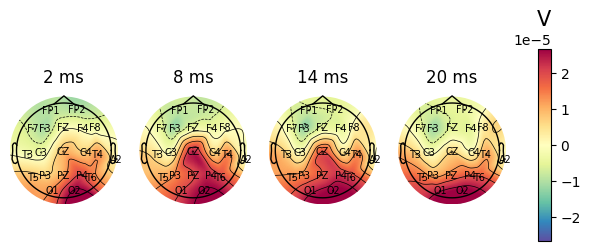

In [69]:
plot_topomap(data, positions, [1,4,7,10])

We can plot the topographic maps not only with respect to time, but also with respect to a specific frequency band.

The topographic maps can be plotted for different frequency bands, such as delta, theta, alpha, beta, and gamma.

(20, 4) (4,)


<Figure size 2000x1000 with 0 Axes>

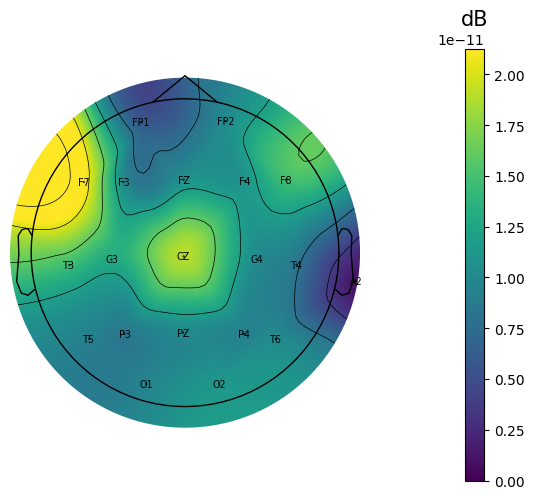

In [71]:
# compute power spectral density (e.g. delta band using welch method)
# by default it computes the mean of the power spectral density across the frequency band
psd_delta, freqs = mne.time_frequency.psd_array_welch(raw.get_data(), sfreq=500, fmin=0.5, fmax=4, n_fft=500, n_overlap=250, verbose=False)
print(psd_delta.shape, freqs.shape) 

# plot topographic map of delta band
plot_topographic_map_freq(psd_delta.mean(axis=1), positions, raw)
